In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

# 1. Get the time series for the following cryptocurrencie

In [14]:
def getData(token):
    res = requests.get(
        'https://api.cryptowat.ch/markets/coinbase-pro/%susd/ohlc'%token,
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        },
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    return df

In [15]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT']  # The API above does not have 'FLOW' 
df= pd.concat([getData(token) for token in tokens])

In [16]:
df.head(5)

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


In [17]:
df.tail(5) 

,ts,open,high,low,close,volume,volumeUSD,token
552,2021-12-15 00:00:00,1.0004,1.0005,1.0004,1.0004,2018733.68,2.019673e+06,USDT
553,2021-12-15 01:00:00,1.0004,1.0005,1.0004,1.0004,1518813.52,1.519515e+06,USDT
554,2021-12-15 02:00:00,1.0005,1.0006,1.0003,1.0005,4364500.01,4.366675e+06,USDT
555,2021-12-15 03:00:00,1.0004,1.0006,1.0004,1.0004,6449893.46,6.453452e+06,USDT
556,2021-12-15 04:00:00,1.0004,1.0005,1.0004,1.0005,1070528.17,1.071025e+06,USDT


# 2.Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume

In [21]:
df.groupby('token').agg({"volumeUSD":"sum"}).reset_index().sort_values(by='volumeUSD', ascending=False)

,token,volumeUSD
1,ETH,2.164708e+10
2,SOL,7.092634e+09
0,AVAX,3.541542e+09
3,USDT,2.020898e+09


# 3. Add a column that calculates the close price ratio between ETH and SOL for each house 

In [39]:
closeSOL=dict(zip(df[df["token"]=="SOL"]["ts"],df[df["token"]=="SOL"]["close"]))

In [41]:
def f(x):
    if(x["token"]=="ETH"):
        return x["close"]/closeSOL[x["ts"]]
    return None
df["ETH_SOL_close_ratio"]=df.apply(f,axis=1)

In [43]:
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,ETH_SOL_close_ratio
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,18.891059


# 4. Change the name of the volume and volumeUSD columns to volumeBase and volumeTerm

In [44]:
df.rename(
    columns={
    'volume': 'volumeBase',
    'volumeUSD': 'volumeTerm',
    },
    inplace=True)

df.head()

,ts,open,high,low,close,volumeBase,volumeTerm,token,ETH_SOL_close_ratio
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,18.891059


# 5. create a fat table indexed by the timestamp, and each column is the close price of each token 

In [46]:
fat_table = pd.pivot(df, index='ts', columns='token', values='close')
fat_table = fat_table[tokens]

fat_table.head()

token,ETH,SOL,AVAX,USDT
ts,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009


In [47]:
fat_table.shape

(557, 4)

# 6. calculate the hour by hour log return of the close price of each token

In [60]:
df['return'] = df.groupby('token')['close'].apply(lambda s: np.log(s).diff())

df.head()

,ts,open,high,low,close,volumeBase,volumeTerm,token,ETH_SOL_close_ratio,return
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,18.471694,NaN
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,18.736150,0.046912
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,18.577985,-0.017279
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,18.794937,0.006318
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,18.891059,0.021583


In [61]:
# get the return time series table
df_return = pd.pivot(df, index='ts', columns='token', values='return')[tokens]

df_return.head()

token,ETH,SOL,AVAX,USDT
ts,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,0.046912,-0.006736,-0.020952,0.0001
2021-11-22 02:00:00,-0.017279,-0.003900,0.004578,-0.0001
2021-11-22 03:00:00,0.006318,-0.005806,-0.017417,-0.0001
2021-11-22 04:00:00,0.021583,-0.006008,-0.011109,-0.0002


# 7.Calculate the correlation among assets

In [64]:
dcorr = df_return.corr(method='pearson')  # correlation matrix
dcorr

token,ETH,SOL,AVAX,USDT
token,,,,
ETH,1.000000,0.642938,0.622144,-0.017033
SOL,0.642938,1.000000,0.743450,-0.118946
AVAX,0.622144,0.743450,1.000000,0.100451
USDT,-0.017033,-0.118946,0.100451,1.000000


# 8. Visualize the correlation

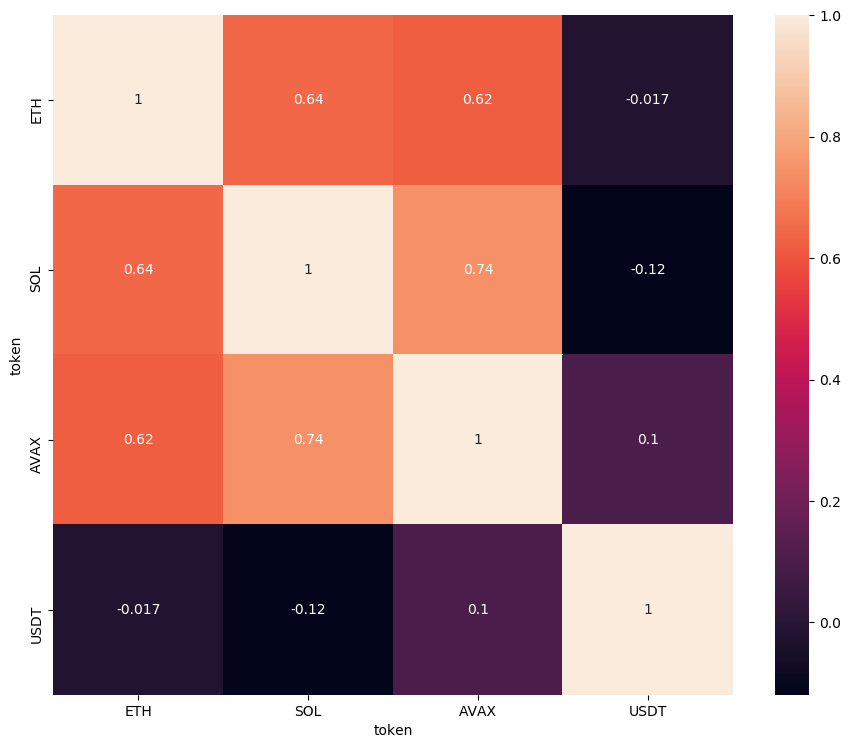

In [69]:

plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data=dcorr,square=True, annot=True)